In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde

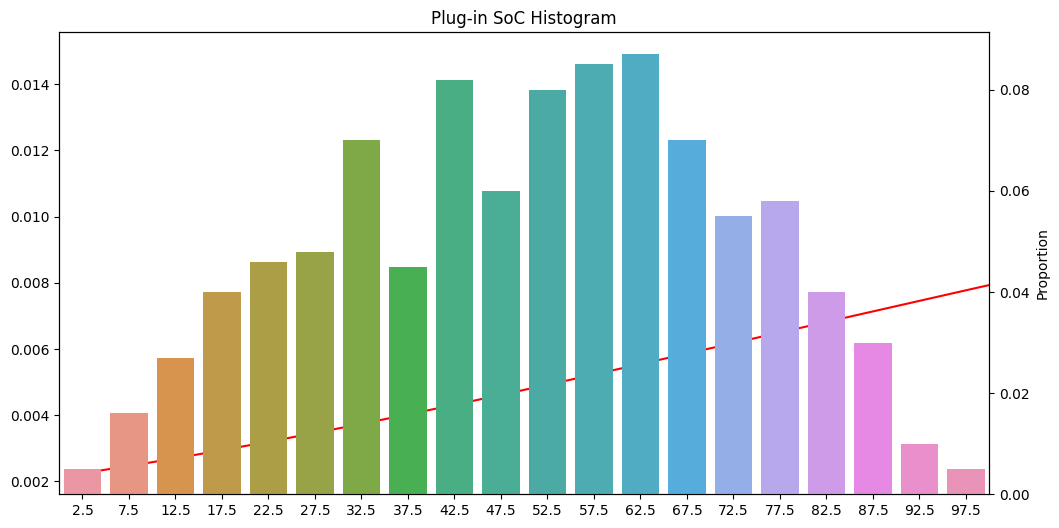

In [75]:
# estimate PDF of plug-in-soc histogram
plug_in_soc_data = {
    2.5: 0.005,
    7.5: 0.016,
    12.5: 0.027,
    17.5: 0.04,
    22.5: 0.046,
    27.5: 0.048,
    32.5: 0.07,
    37.5: 0.045,
    42.5: 0.082,
    47.5: 0.06,
    52.5: 0.08,
    57.5: 0.085,
    62.5: 0.087,
    67.5: 0.07,
    72.5: 0.055,
    77.5: 0.058,
    82.5: 0.04,
    87.5: 0.03,
    92.5: 0.01,
    97.5: 0.005,
}

plug_in_soc_df = pd.DataFrame.from_dict(plug_in_soc_data, orient='index').reset_index()
plug_in_soc_df.columns = ['plug_in_soc', 'proportion']
mean = plug_in_soc_df['plug_in_soc'] * plug_in_soc_df['proportion']
g_kde = gaussian_kde(plug_in_soc_df['plug_in_soc'], weights=plug_in_soc_df['proportion'])
x = np.linspace(0, 100, 1000)
y = g_kde(x)

fig, ax1 = plt.subplots(figsize=(12,6))
sns.lineplot(x=x, y=y, color='red', ax=ax1)
ax2 = ax1.twinx()
sns.barplot(x='plug_in_soc', y='proportion', data=plug_in_soc_df, ax=ax2)

plt.xlabel('Plug-in SoC')
plt.ylabel('Proportion')
plt.title('Plug-in SoC Histogram')
plt.show()

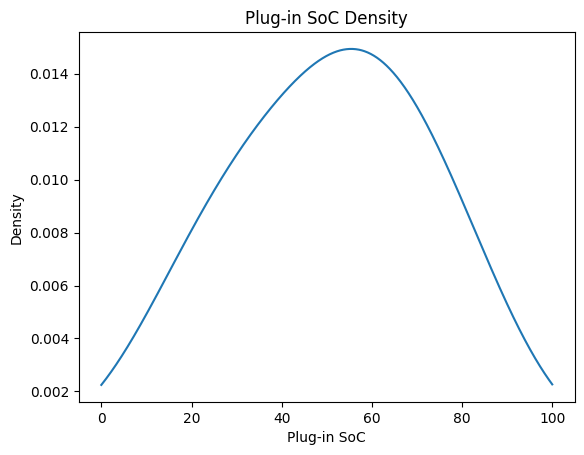

In [66]:
# plot g_kde
x = np.linspace(0, 100, 1000)
y = g_kde(x)
plt.plot(x, y)
plt.xlabel('Plug-in SoC')
plt.ylabel('Density')
plt.title('Plug-in SoC Density')
plt.show()

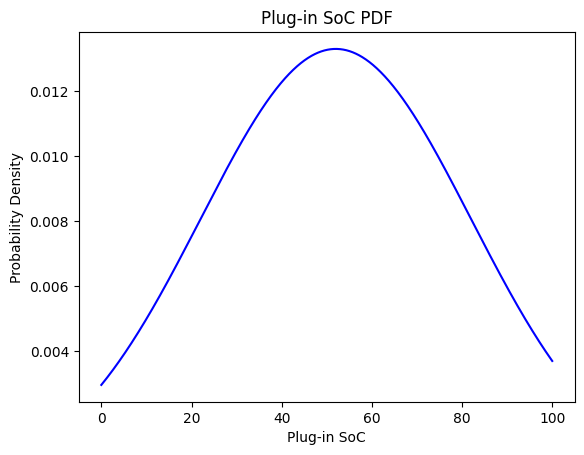

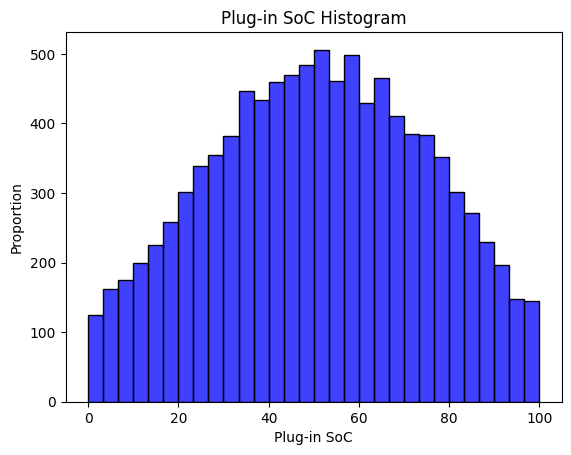

In [58]:
# estimate PDF of plug-in soc
from scipy.stats import norm
from scipy.stats.sampling import NumericalInversePolynomial

class StandardNormal:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def pdf(self, x):
        return norm.pdf(x, loc=self.mean, scale=self.std)
    
mean = 52
std = 30
plug_in_soc_pdf = StandardNormal(mean, std)

x = np.linspace(0, 100, 1000)
y = plug_in_soc_pdf.pdf(x)

plt.plot(x, y, color='blue')
plt.xlabel('Plug-in SoC')
plt.ylabel('Probability Density')
plt.title('Plug-in SoC PDF')
plt.show()

# inverse cdf
inverse_cdf = NumericalInversePolynomial(plug_in_soc_pdf, domain=(0, 100))
inverse_cdf_samples = inverse_cdf.rvs(size=10000)

sns.histplot(inverse_cdf_samples, color='blue')
plt.xlabel('Plug-in SoC')
plt.ylabel('Proportion')
plt.title('Plug-in SoC Histogram')
plt.show()

In [57]:
inverse_cdf_samples.max()

99.93553719914391